## K Means Clustering

In [144]:
# adapted from: https://github.com/brandomr/document_cluster/blob/master/cluster_analysis_web.ipynb

### Overview: TD-IDF vectorization, cluster based on centroid
#### TODO: Need to add a metric for all implementations to compare. Try soft k-means or fuzzy clustering

In [145]:
import pandas as pd
import re
import nltk
from nltk.stem import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer


In [146]:
df = pd.read_csv('abstracts.csv')
titles = df.Title.values
document_list = df.Text.values

In [147]:
# Snowball Stemmer is more aggressive than Porter Stemmer. It is newer than Porter.
stemmer = SnowballStemmer("english")
p_stemmer = PorterStemmer()

In [148]:
def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems

In [149]:
#define vectorizer parameters
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=200000,
                                 min_df=0.2, stop_words='english',
                                 use_idf=True, tokenizer=tokenize_and_stem, ngram_range=(1,3))

tfidf_matrix = tfidf_vectorizer.fit_transform(document_list) #fit the vectorizer to synopses

/opt/anaconda3/envs/USGS_1/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:386: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'forti', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'mani', 'meanwhil', 'moreov', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'togeth', 'twelv', 'twenti', 'veri', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [150]:
num_clusters = 6

km = KMeans(n_clusters=num_clusters)

km.fit(tfidf_matrix)

clusters = km.labels_.tolist()
df['clusters'] = clusters

### Examine Clusters

In [151]:
frame = pd.DataFrame(df, index = [clusters] , columns = ['Title', 'Text', 'Keywords_manual', 'cluster'])

In [152]:
frame.index.value_counts() 

(1,)    9
(4,)    8
(3,)    7
(2,)    7
(0,)    5
(5,)    4
dtype: int64

In [153]:
cluster_ind = []
cluster_words = []
cluster_titles = []
for i in range(num_clusters):
    cluster_ind.append(i)
    cluster_titles.append(df.Title[df.clusters == i])
    cluster_temp = []
    for j in (df.Text[df.clusters == i]):
        cluster_temp.append(j)
    cluster_words.append([j])

In [154]:
for i in cluster_ind:
    print('cluster', cluster_ind[i])
    print()
    print(cluster_titles[i])
    print(cluster_words[i])

cluster 0

5     THE COMPUTER MODEL SHARP, A QUASI-THREE-DIMENS...
10    1DTempPro V2: New Features for Inferring Groun...
19    VFLUX: Vertical Fluid Heat Transfer Solver (VF...
20    Slab2, a comprehensive subduction zone geometr...
36    MODFLOW-NWT, A Newton Formulation for MODFLOW-...
Name: Title, dtype: object
['This report documents a Newton formulation of MODFLOW-2005, called MODFLOW-NWT. MODFLOW-NWT is a standalone program that is intended for solving problems involving drying and rewetting nonlinearities of the unconfined groundwater-flow equation. MODFLOW-NWT must be used with the Upstream-Weighting (UPW) Package for calculating intercell conductances in a different manner than is done in the Block-Centered Flow (BCF), Layer Property Flow (LPF), or Hydrogeologic-Unit Flow (HUF; Anderman and Hill, 2000) Packages.\nThe UPW Package treats nonlinearities of cell drying and rewetting by use of a continuous function of groundwater head, rather than the discrete approach of drying 

In [155]:
import os  # for os.path.basename

import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.manifold import MDS
from sklearn.metrics.pairwise import cosine_similarity

dist = 1 - cosine_similarity(tfidf_matrix)

MDS()

# convert two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

xs, ys = pos[:, 0], pos[:, 1]
print()

No handles with labels found to put in legend.


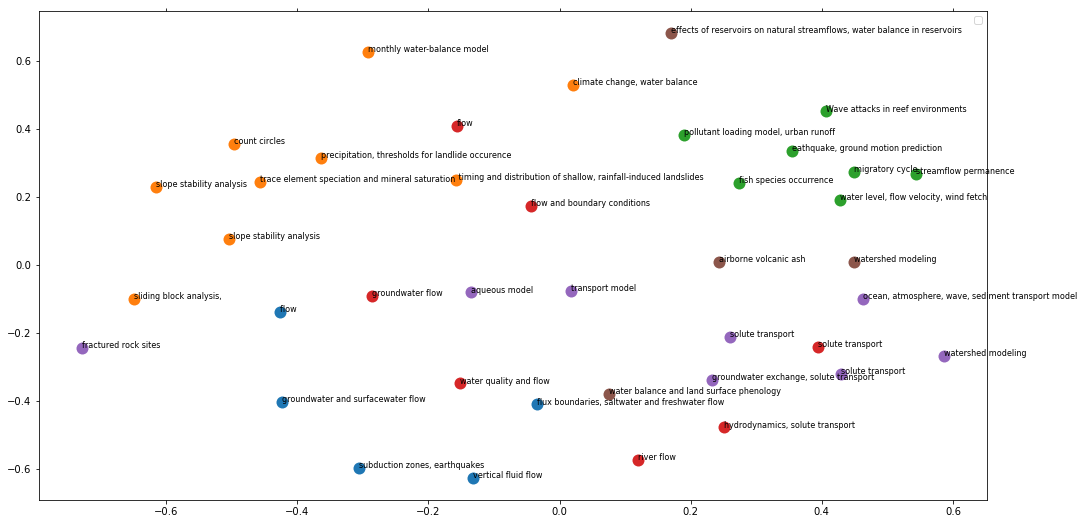

In [156]:
# some ipython magic to show the matplotlib plots inline
%matplotlib inline 

#create data frame that has the result of the MDS plus the cluster numbers and titles
df2 = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=df.Keywords_manual)) 

#group by cluster
groups = df2.groupby('label')


# set up plot
fig, ax = plt.subplots(figsize=(17, 9)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    
ax.legend(numpoints=1)  #show legend with only 1 point

#add label in x,y position with the label as the film title
for i in range(len(df)):
    ax.text(df2.iloc[i]['x'], df2.iloc[i]['y'], df2.iloc[i]['title'], size=8)  

plt.show() #show the plot

#uncomment the below to save the plot if need be
#plt.savefig('clusters_small_noaxes.png', dpi=200)